In [1]:
!pip install torch torchvision albumentations opencv-python matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.1

In [2]:
import os
import argparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss, box_iou
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
class TrafficDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = np.array(Image.open(img_path).convert("RGB"))
        label_path = os.path.join(self.labels_dir, os.path.splitext(self.image_files[idx])[0] + '.txt')
        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, x_c, y_c, w, h = map(float, line.split())
                    h_img, w_img = img.shape[:2]
                    x_c, y_c = x_c * w_img, y_c * h_img
                    w, h = w * w_img, h * h_img
                    x0, y0 = x_c - w/2, y_c - h/2
                    x1, y1 = x_c + w/2, y_c + h/2
                    boxes.append([x0, y0, x1, y1])
                    labels.append(int(cls) + 1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        if boxes.numel() > 0:
            valid = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[valid]
            labels = labels[valid]
        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.numel() else torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area, "iscrowd": iscrowd}
        if self.transforms:
            labs = labels.tolist()
            transformed = self.transforms(image=img, bboxes=target["boxes"], labels=labs)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
            target["labels"] = torch.as_tensor(transformed["labels"], dtype=torch.int64)
        else:
            img = ToTensorV2()(image=img)["image"]
        return img, target

In [4]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(300, 300), A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(300, 300),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [5]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))

In [6]:
def det_precision_recall_f1(preds, targets, iou_thresh=0.5):
    tp = fp = fn = 0
    for pred, tgt in zip(preds, targets):
        boxes_p, scores_p = pred['boxes'], pred['scores']
        boxes_t = tgt['boxes']
        keep = scores_p > 0.25
        boxes_p = boxes_p[keep]
        if boxes_p.numel() == 0 and boxes_t.numel() == 0:
            continue
        if boxes_p.numel() == 0:
            fn += boxes_t.shape[0]
            continue
        if boxes_t.numel() == 0:
            fp += boxes_p.shape[0]
            continue
        iou = box_iou(boxes_p, boxes_t)
        matched_t = set()
        for i in range(iou.shape[0]):
            j = torch.argmax(iou[i])
            if iou[i, j] >= iou_thresh and j.item() not in matched_t:
                tp += 1
                matched_t.add(j.item())
            else:
                fp += 1
        fn += boxes_t.shape[0] - len(matched_t)
    prec = tp / (tp + fp) if tp + fp > 0 else 0
    rec = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0
    return prec, rec, f1

In [7]:
def main(args):
    train_ds = TrafficDataset(args.train_images, args.train_labels, transforms=get_transforms(True))
    val_ds   = TrafficDataset(args.val_images,   args.val_labels,   transforms=get_transforms(False))
    counts = {i:0 for i in range(1,args.num_classes)}
    img_w = []
    for i in range(len(train_ds)):
        _, tgt = train_ds[i]
        labels = tgt['labels'].tolist()
        for l in labels: counts[l]+=1
        w = sum(1.0/counts[l] for l in set(labels)) if labels else 0
        img_w.append(w)
    sampler = WeightedRandomSampler(img_w, num_samples=len(img_w), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, sampler=sampler,
                              num_workers=args.num_workers, pin_memory=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=args.batch_size, shuffle=False,
                              num_workers=args.num_workers, pin_memory=True, collate_fn=collate_fn)

    weights = SSD300_VGG16_Weights.DEFAULT
    model = ssd300_vgg16(weights=weights)
    
    # Replace the classifier head to match your number of classes (including background)
    # Make sure args.num_classes includes background (e.g., 2 if it's binary classification with background)
    model.head.classification_head.num_classes = args.num_classes
  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    if args.scheduler == 'onecycle':
        sched = torch.optim.lr_scheduler.OneCycleLR(
            opt,
            max_lr=args.lr,
            steps_per_epoch=len(train_loader),
            epochs=args.epochs
        )
    else:
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt,
            T_max=args.epochs
        )

    scaler = GradScaler()
    map_metric = MeanAveragePrecision()
    history = {'train_loss':[], 'val_loss':[], 'mAP50':[], 'mAP5095':[], 'precision':[], 'recall':[], 'f1':[], 'lr':[]}
    best_loss = float('inf')
    no_improve = {0:[], 'val_loss':[], 'mAP50':[], 'mAP5095':[], 'precision':[], 'recall':[], 'f1':[], 'lr':[]}
    best_loss= float('inf'); no_improve=0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for epoch in range(1, args.epochs+1):
        model.train(); tloss=0
        loop = tqdm(train_loader, desc=f"Train {epoch}/{args.epochs}")
        for step,(imgs,tgts) in enumerate(loop):
            imgs = [i.to(device) for i in imgs]
            tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]
            with autocast(): loss = sum(model(imgs,tgts).values())
            opt.zero_grad(); scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
            tloss+=loss.item(); loop.set_postfix(loss=tloss/(step+1))
        sched.step()

        vloss=0; model.train();
        with torch.no_grad():
            for imgs,tgts in val_loader:
                imgs = [i.to(device) for i in imgs]
                tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]
                with autocast(): vloss+=sum(model(imgs,tgts).values()).item()
        vloss/=len(val_loader)

        model.eval(); all_preds,all_tgts=[],[]
        with torch.no_grad():
            for imgs,tgts in val_loader:
                imgs = [i.to(device) for i in imgs]
                tgts = [{k:v.to(device) for k,v in t.items()} for t in tgts]
                out=model(imgs)
                for o,t in zip(out,tgts): all_preds.append({'boxes':o['boxes'].cpu(),'scores':o['scores'].cpu(),'labels':o['labels'].cpu()}); all_tgts.append({'boxes':t['boxes'].cpu(),'labels':t['labels'].cpu()})
                map_metric.update(all_preds, all_tgts)
        mres=map_metric.compute(); prec,rec,f1 = det_precision_recall_f1(all_preds,all_tgts)

        history['train_loss'].append(tloss/len(train_loader)); history['val_loss'].append(vloss)
        history['mAP50'].append(mres['map_50'].item()); history['mAP5095'].append(mres['map'].item())
        history['precision'].append(prec); history['recall'].append(rec); history['f1'].append(f1)
        history['lr'].append(opt.param_groups[0]['lr'])

        print(f"Epoch {epoch}/{args.epochs} TLoss:{tloss/len(train_loader):.3f} VLoss:{vloss:.3f} mAP50:{mres['map_50']:.3f} mAP@[.50:.95]:{mres['map']:.3f} P/R/F1:{prec:.3f}/{rec:.3f}/{f1:.3f}")
        if tloss<best_loss: best_loss,no_improve=tloss,0; torch.save(model.state_dict(),os.path.join(args.output,'best.pth'))
        else: no_improve+=1
        if epoch%10==0: torch.save(model.state_dict(),os.path.join(args.output,f'epoch_{epoch}.pth'))
        torch.save(model.state_dict(),os.path.join(args.output,'last.pth'))
        if no_improve>=args.patience: print(f"Early stopping at epoch {epoch}"); break

    return history

In [8]:
def plot_history(history,output):
    epochs=list(range(1,len(history['train_loss'])+1))
    plt.figure(figsize=(8,5)); plt.plot(epochs, history['train_loss'], label='Train Loss'); plt.plot(epochs, history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.savefig(os.path.join(output,'loss.png')); plt.show()
    plt.figure(figsize=(8,5)); plt.plot(epochs, history['mAP50'], label='mAP@50'); plt.plot(epochs, history['mAP5095'], label='mAP@[.50:.95]'); plt.title('mAP'); plt.xlabel('Epoch'); plt.ylabel('mAP'); plt.legend(); plt.savefig(os.path.join(output,'mAP.png')); plt.show()
    plt.figure(figsize=(8,5)); plt.plot(epochs, history['precision'], label='Precision'); plt.plot(epochs, history['recall'], label='Recall'); plt.plot(epochs, history['f1'], label='F1'); plt.title('P/R/F1'); plt.xlabel('Epoch'); plt.ylabel('Value'); plt.legend(); plt.savefig(os.path.join(output,'prf1.png')); plt.show()
    plt.figure(figsize=(8,5)); plt.plot(epochs, history['lr'], label='Learning Rate'); plt.title('LR'); plt.xlabel('Epoch'); plt.ylabel('LR'); plt.legend(); plt.savefig(os.path.join(output,'lr.png')); plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 220MB/s] 
/tmp/ipykernel_35/1303220096.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train 1/25:   0%|          | 0/47 [00:00<?, ?it/s]

/tmp/ipykernel_35/1303220096.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): loss = sum(model(imgs,tgts).values())
/tmp/ipykernel_35/1303220096.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): vloss+=sum(model(imgs,tgts).values()).item()
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


Epoch 1/25 TLoss:6.238 VLoss:3.893 mAP50:0.213 mAP@[.50:.95]:0.119 P/R/F1:0.706/0.461/0.558


Train 2/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/25 TLoss:3.078 VLoss:3.440 mAP50:0.246 mAP@[.50:.95]:0.136 P/R/F1:0.800/0.497/0.614


Train 3/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/25 TLoss:2.464 VLoss:3.303 mAP50:0.256 mAP@[.50:.95]:0.143 P/R/F1:0.803/0.504/0.619


Train 4/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/25 TLoss:2.230 VLoss:3.152 mAP50:0.269 mAP@[.50:.95]:0.152 P/R/F1:0.824/0.517/0.636


Train 5/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/25 TLoss:2.040 VLoss:3.035 mAP50:0.280 mAP@[.50:.95]:0.159 P/R/F1:0.825/0.522/0.639


Train 6/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/25 TLoss:1.837 VLoss:2.999 mAP50:0.287 mAP@[.50:.95]:0.163 P/R/F1:0.829/0.546/0.658


Train 7/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/25 TLoss:1.703 VLoss:2.936 mAP50:0.296 mAP@[.50:.95]:0.168 P/R/F1:0.834/0.555/0.667


Train 8/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/25 TLoss:1.624 VLoss:2.956 mAP50:0.304 mAP@[.50:.95]:0.172 P/R/F1:0.826/0.564/0.670


Train 9/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/25 TLoss:1.502 VLoss:2.959 mAP50:0.311 mAP@[.50:.95]:0.176 P/R/F1:0.833/0.564/0.672


Train 10/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/25 TLoss:1.466 VLoss:2.848 mAP50:0.320 mAP@[.50:.95]:0.181 P/R/F1:0.854/0.570/0.684


Train 11/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/25 TLoss:1.411 VLoss:2.866 mAP50:0.327 mAP@[.50:.95]:0.184 P/R/F1:0.842/0.573/0.682


Train 12/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/25 TLoss:1.257 VLoss:2.915 mAP50:0.335 mAP@[.50:.95]:0.188 P/R/F1:0.861/0.574/0.689


Train 13/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/25 TLoss:1.258 VLoss:2.840 mAP50:0.341 mAP@[.50:.95]:0.192 P/R/F1:0.834/0.603/0.700


Train 14/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/25 TLoss:1.125 VLoss:2.930 mAP50:0.346 mAP@[.50:.95]:0.193 P/R/F1:0.824/0.600/0.694


Train 15/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/25 TLoss:1.107 VLoss:2.828 mAP50:0.353 mAP@[.50:.95]:0.197 P/R/F1:0.845/0.597/0.700


Train 16/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/25 TLoss:1.021 VLoss:2.829 mAP50:0.359 mAP@[.50:.95]:0.200 P/R/F1:0.841/0.616/0.711


Train 17/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/25 TLoss:1.065 VLoss:2.876 mAP50:0.366 mAP@[.50:.95]:0.203 P/R/F1:0.855/0.604/0.708


Train 18/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/25 TLoss:0.985 VLoss:2.888 mAP50:0.372 mAP@[.50:.95]:0.206 P/R/F1:0.855/0.611/0.712


Train 19/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/25 TLoss:1.009 VLoss:2.845 mAP50:0.378 mAP@[.50:.95]:0.208 P/R/F1:0.858/0.624/0.722


Train 20/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/25 TLoss:0.950 VLoss:2.867 mAP50:0.383 mAP@[.50:.95]:0.211 P/R/F1:0.863/0.642/0.737


Train 21/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/25 TLoss:0.903 VLoss:2.867 mAP50:0.388 mAP@[.50:.95]:0.214 P/R/F1:0.837/0.641/0.726


Train 22/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/25 TLoss:0.892 VLoss:2.849 mAP50:0.392 mAP@[.50:.95]:0.216 P/R/F1:0.851/0.643/0.733


Train 23/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/25 TLoss:0.865 VLoss:2.908 mAP50:0.397 mAP@[.50:.95]:0.218 P/R/F1:0.852/0.658/0.742


Train 24/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/25 TLoss:0.823 VLoss:2.892 mAP50:0.402 mAP@[.50:.95]:0.221 P/R/F1:0.849/0.658/0.741


Train 25/25:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/25 TLoss:0.801 VLoss:2.924 mAP50:0.406 mAP@[.50:.95]:0.223 P/R/F1:0.867/0.641/0.737


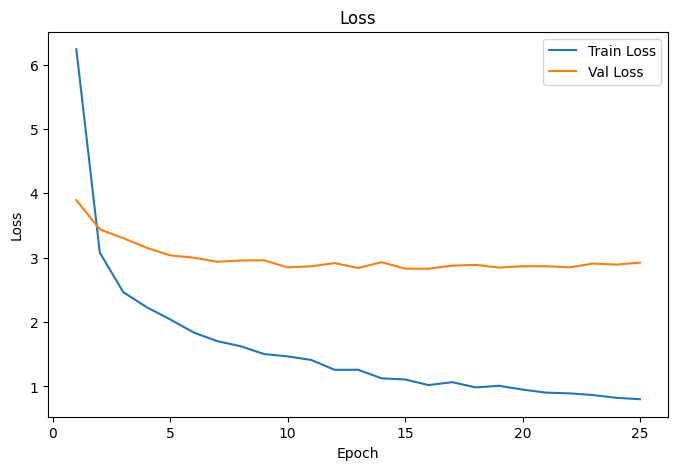

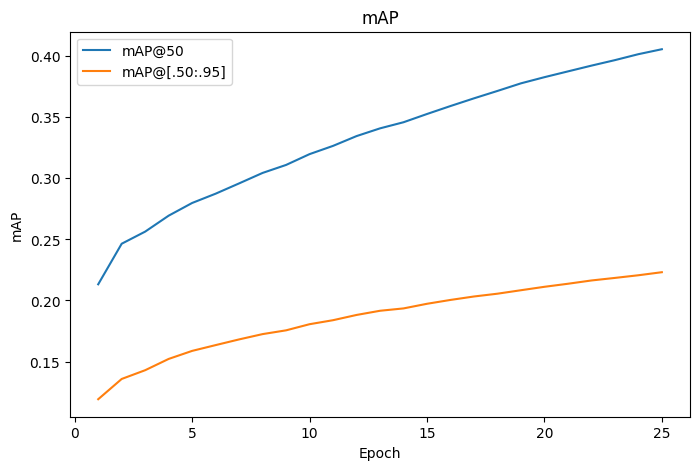

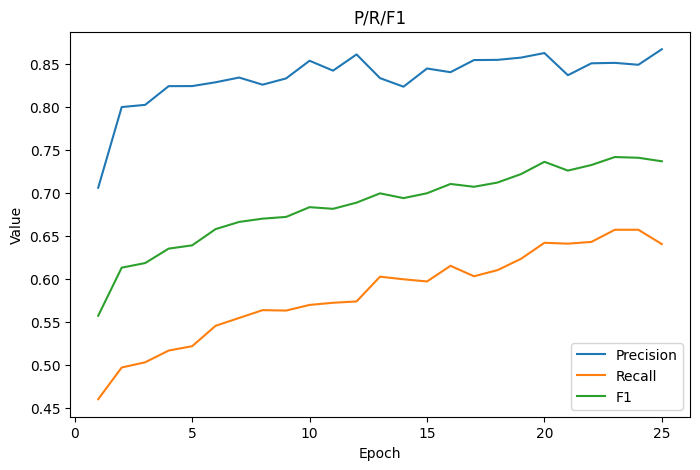

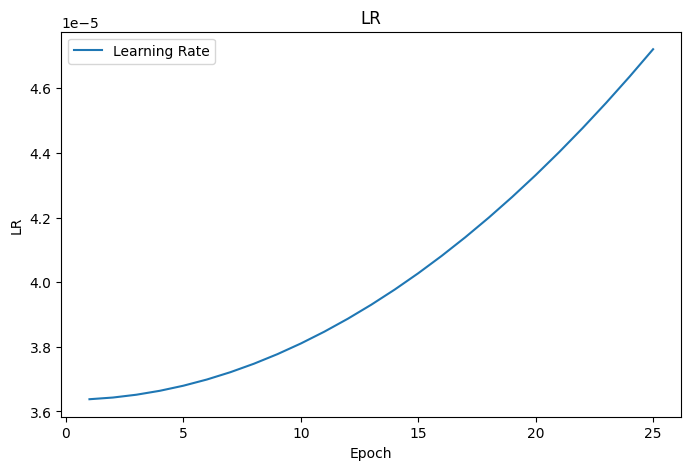

In [9]:
if __name__=='__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--train_images', default='/kaggle/input/traffic-vehicles-object-detection/Traffic Dataset/images/train')
    parser.add_argument('--train_labels', default='/kaggle/input/traffic-vehicles-object-detection/Traffic Dataset/labels/train')
    parser.add_argument('--val_images', default='/kaggle/input/traffic-vehicles-object-detection/Traffic Dataset/images/val')
    parser.add_argument('--val_labels', default='/kaggle/input/traffic-vehicles-object-detection/Traffic Dataset/labels/val')
    parser.add_argument('--output', default='checkpoints')
    parser.add_argument('--epochs', type=int, default=25)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--lr', type=float, default=0.000909)
    parser.add_argument('--weight_decay', type=float, default=0.0005)
    parser.add_argument('--scheduler', choices=['onecycle','cosine'], default='onecycle')
    parser.add_argument('--num_workers', type=int, default=0)
    parser.add_argument('--patience', type=int, default=20)
    parser.add_argument('--num_classes', type=int, default=8)
    args,_=parser.parse_known_args()
    os.makedirs(args.output, exist_ok=True)
    history = main(args)
    plot_history(history, args.output)